<a href="https://colab.research.google.com/github/brunobro/classification-of-tropical-forage-grass-using-na-ve-bayes-and-kernel-density-estimation/blob/main/ClassificationForageGrassWithKDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classification of Tropical Forage Grass Varieties Under Moderate and Severe Water Stress using Naïve Bayes and Kernel Density Estimation**

**Authors:** Bruno Rodrigues de Oliveira, Renato Lustosa Sobrinho, Marco Aparecido Queiroz Duarte

**Abstract:** The selection of forage grasses that are more adapted to adverse conditions, such as water scarcity or dry rain periods, is extremely important. Mainly due to the severe climate changes, and the search for more sustainable ways of farming. Forage grasses form the basis of the diet of beef cattle and are also used as a source of biofuels, for erosion control and soil improvement. This work presents a machine learning methodology to obtain classification models for nine forage cultivars, subject to moderate and severe water stress. The Naïve Bayes algorithm is used together with the Kernel Density Estimation method to obtain the densities used in the classification models. Before learning the models, the grouped cross-validation technique and also the grid search are used to search for the best set of hyperparameters. The best accuracy and precision results are 0.88 and 0.90, respectively. It is observed that the classification performance depends on the cultivars used in the training and test sets. At the end, the estimated probability densities are also analyzed by comparing them with some statistics obtained for each variable and water stress or control environments.

**Used Variables**
* PH plant hieght
* NP number of tillers
* NS number of sheets
* RV root volume
* LA Leaf Area
* SDM shoot dry matter
* RDM root dry matter


In [ ]:
import numpy as np
np.seterr(invalid='ignore')

import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

from scipy import stats

from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# KDE custom  python function

In [ ]:
'''
Author: Jake VanderPlas
https://www.oreilly.com/library/view/python-data-science/9781491912126/
https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

Adapted by Bruno R. de Oliveira
'''
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE

    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity among 'gaussian','tophat','epanechnikov','exponential','linear','cosine'
    distance: str
        distance metric among 'euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis'
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian', distance='euclidean'):
        self.bandwidth = bandwidth
        self.kernel    = kernel
        self.distance  = distance

    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]

        self.models_ = []
        for i, Xi in enumerate(training_sets):
            self.models_.append(KernelDensity(bandwidth=self.bandwidth, kernel=self.kernel, metric=self.distance).fit(Xi))

        return self

    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

# Show KDE example

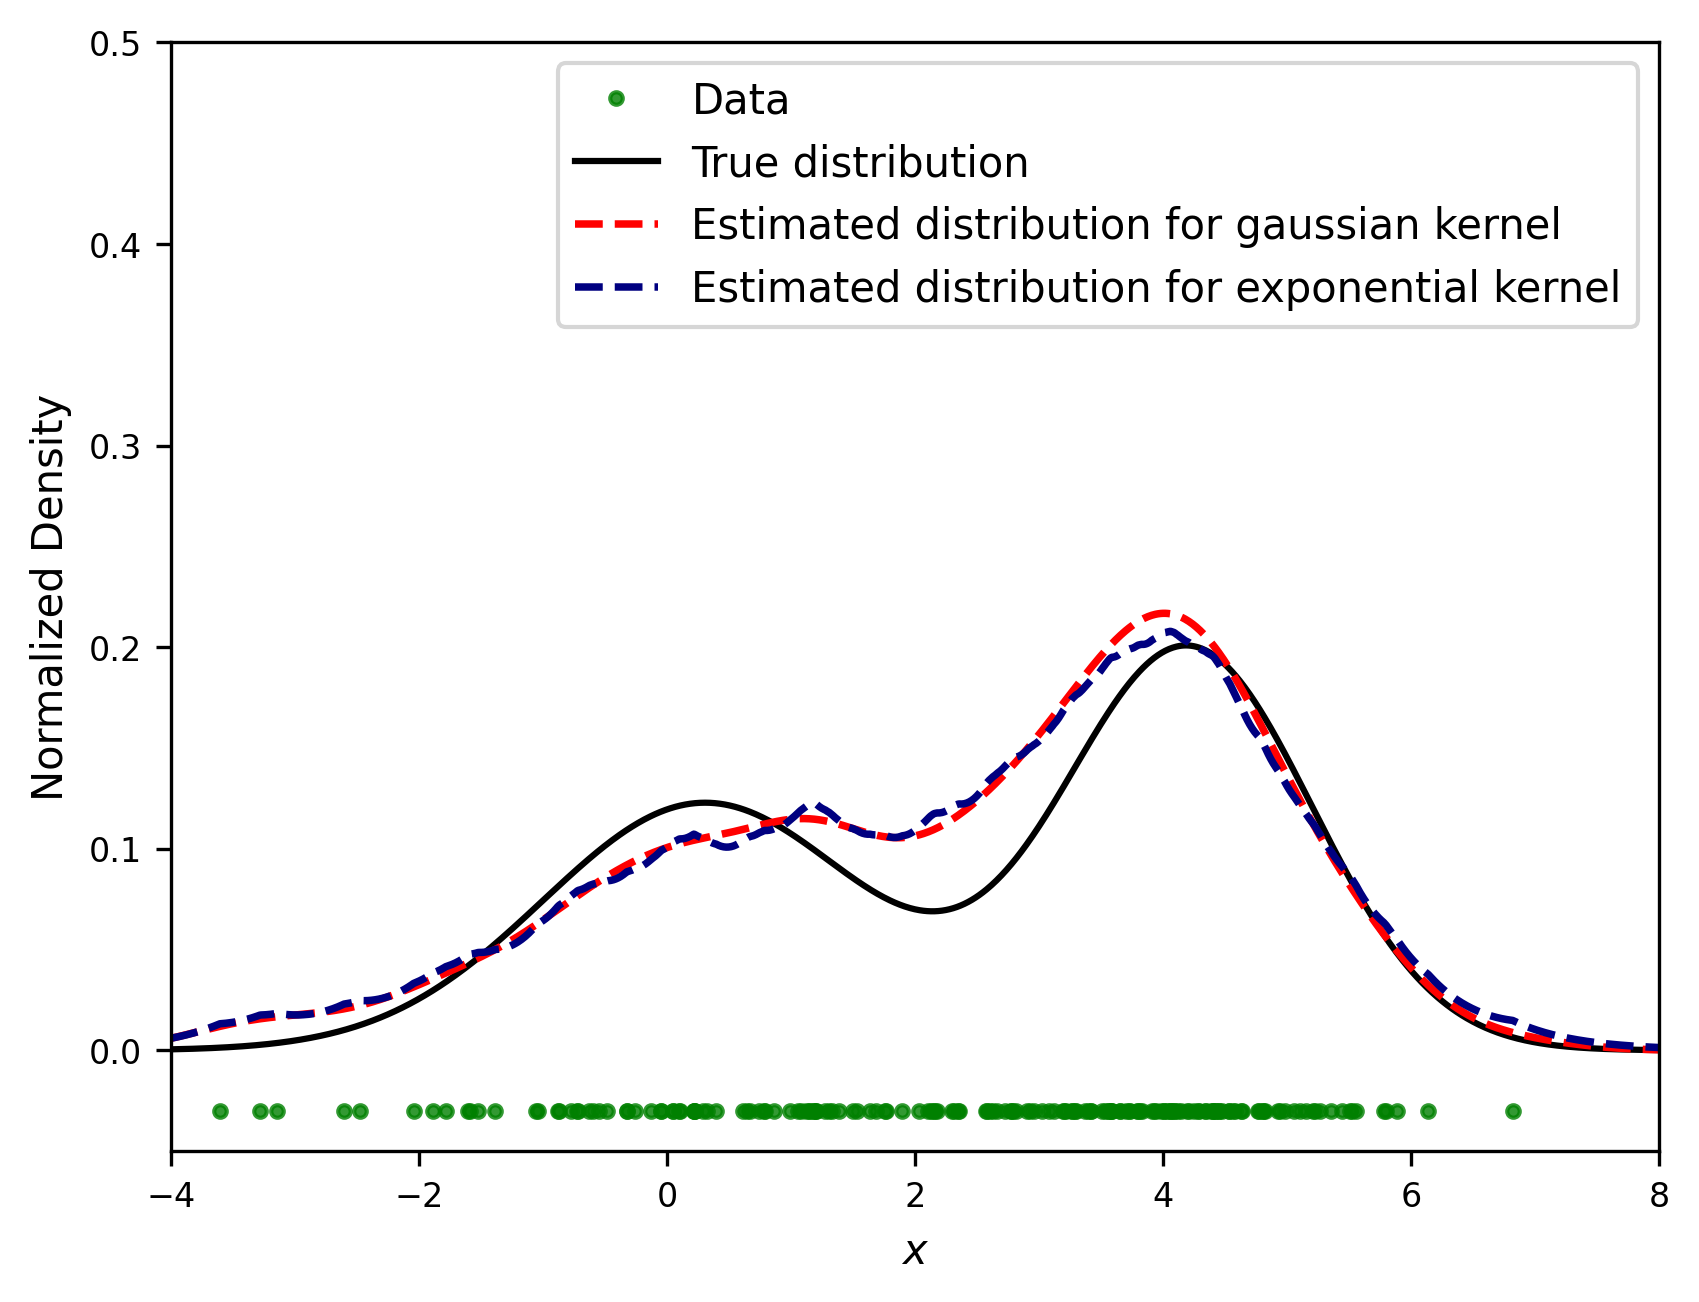

In [ ]:
'''
Show an example of KDE use
'''
from scipy.stats import norm

# Parameters for 200 points
N = 200

X0m = 0.3
X0s = 1.3
X0a = 0.4
X0  = np.random.normal(X0m, X0s, int(X0a * N))

X1m = 4.2
X1s = 1
X1a = 0.5
X1  = np.random.normal(X1m, X1s, int(X1a * N))

# Data
X  = np.concatenate((X0, X1))[:, np.newaxis]
Xp = np.linspace(-10, 10, 2000)[:, np.newaxis]

# Create a true density
density = X0a * norm(X0m, X0s).pdf(Xp[:, 0]) + X1a * norm(X1m, X1s).pdf(Xp[:, 0])

fig, ax = plt.subplots(dpi=300)
ax.plot(X[:, 0], -0.03 - np.zeros(X.shape[0]), ".g", label='Data', alpha=0.8)
ax.plot(Xp[:, 0], density, color='black', label="True distribution")

colors  = ["red", "navy"]
kernels = ["gaussian", "exponential"]

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(Xp)
    ax.plot(Xp[:, 0], np.exp(log_dens), color=color, lw=1.8, linestyle='--', label="Estimated distribution for {0} kernel".format(kernel))

ax.legend(loc="best")
ax.set_xlabel('$x$')
ax.set_ylabel('Normalized Density')
ax.set_xlim(-4, 8)
ax.set_ylim(-0.05, 0.5)
plt.show()

# Load and format dataset

In [ ]:
#Load data
df = pd.read_excel('data.xlsx')
del df['Repetition']

y        = np.array(df['Class'])
Classes  = np.unique(y)
Cultivar = np.array(df['Cultivar'])
df_      = df.copy()

del df_['Class']
del df_['Cultivar']
del df_['TDM']

Vars = df_.columns

X = np.array(df_, dtype=np.float32)

print('Dataset - General')
display(df)

print('Dataset - Variables only')
display(df_)

Dataset - General


,Cultivar,Class,PH,NT,NGL,RV,LA,SDM,RDM,TDM
0,ADR 300,Control,157.55,6.000000,29.333333,43.333333,1.734592,27.556667,5.780000,33.336667
1,ADR 300,Control,143.75,4.000000,22.666667,53.333333,1.277615,29.520000,4.263333,33.783333
2,ADR 300,Control,161.00,5.333333,26.666667,63.333333,1.935405,26.803333,6.090000,32.893333
3,ADR 300,Moderate,126.50,3.666667,21.333333,33.333333,1.546401,20.796667,5.730000,26.526667
4,ADR 300,Moderate,132.25,3.666667,17.333333,31.666667,1.234969,20.876667,5.386667,26.263333
...,...,...,...,...,...,...,...,...,...,...
76,Xaraés,Moderate,58.00,12.000000,26.000000,40.000000,13.857191,18.973333,10.626667,29.600000
77,Xaraés,Moderate,52.00,13.000000,27.000000,66.666667,12.878484,21.646667,14.223333,35.870000
78,Xaraés,Severe,52.00,8.666667,18.666667,33.333333,11.081393,13.103333,10.770000,23.873333
79,Xaraés,Severe,46.00,8.666667,16.666667,32.000000,6.104909,13.796667,8.500000,22.296667


Dataset - Variables only


,PH,NT,NGL,RV,LA,SDM,RDM
0,157.55,6.000000,29.333333,43.333333,1.734592,27.556667,5.780000
1,143.75,4.000000,22.666667,53.333333,1.277615,29.520000,4.263333
2,161.00,5.333333,26.666667,63.333333,1.935405,26.803333,6.090000
3,126.50,3.666667,21.333333,33.333333,1.546401,20.796667,5.730000
4,132.25,3.666667,17.333333,31.666667,1.234969,20.876667,5.386667
...,...,...,...,...,...,...,...
76,58.00,12.000000,26.000000,40.000000,13.857191,18.973333,10.626667
77,52.00,13.000000,27.000000,66.666667,12.878484,21.646667,14.223333
78,52.00,8.666667,18.666667,33.333333,11.081393,13.103333,10.770000
79,46.00,8.666667,16.666667,32.000000,6.104909,13.796667,8.500000


# Shapiro-Wilk test and statistics

In [ ]:
'''
Shapiro Statistical Tests for Normality
If the p-value ≤ 0.05, then we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.
If the p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.
'''

alpha = 0.05

for cls in Classes:
    print('\nClass: ', cls)

    df_sel = df[df['Class'] == cls]

    for var in Vars:
        print('\nVariable: ', var)
        w, pvalue = stats.shapiro(df_sel[var])
        print('Statistic: ', w, ' | p-value: ', pvalue)
        if pvalue > alpha:
            print('\t\t Distribution is normal (fail to reject H0)')
        else:
            print('\t\t Distribution is not normal (reject H0)')

        print('Kurtosis: ', stats.kurtosis(df_sel[var]))
        print('Skewness: ', stats.skew(df_sel[var]))



Class:  Control

Variable:  PH
Statistic:  0.7908239364624023  | p-value:  9.531839896226302e-05
		 Distribution is not normal (reject H0)
Kurtosis:  2.1299685616242634
Skewness:  1.6312190578888606

Variable:  NT
Statistic:  0.960757315158844  | p-value:  0.3845153748989105
		 Distribution is normal (fail to reject H0)
Kurtosis:  0.09617371846850409
Skewness:  0.24562836610025285

Variable:  NGL
Statistic:  0.7624588012695312  | p-value:  3.271367313573137e-05
		 Distribution is not normal (reject H0)
Kurtosis:  1.9722416208249012
Skewness:  1.6790305155022744

Variable:  RV
Statistic:  0.9610551595687866  | p-value:  0.3905085027217865
		 Distribution is normal (fail to reject H0)
Kurtosis:  -0.8979097731124317
Skewness:  0.24233417439445618

Variable:  LA
Statistic:  0.9698641300201416  | p-value:  0.5982255339622498
		 Distribution is normal (fail to reject H0)
Kurtosis:  -0.17284183165203437
Skewness:  -0.19257276681585123

Variable:  SDM
Statistic:  0.955772876739502  | p-value:

# Check the best parameters

In [ ]:
'''
Check the best parameters
Extracted cross-validation was used to prevent a sample of the same genotype from being in both the training set and the test set.
'''
np.seterr(divide='ignore', invalid='ignore')

param_grid = {
    'bandwidth': 10 ** np.linspace(0, 2, 100),
    'kernel': ['gaussian','tophat','epanechnikov','exponential','linear','cosine'],
    'distance': ['euclidean', 'manhattan', 'chebyshev']}

group_kfold = GroupKFold(n_splits=5)
cvspliter   = group_kfold.split(X, y, Cultivar)

clf = GridSearchCV(KDEClassifier(), param_grid, cv=cvspliter, scoring='accuracy', return_train_score=True)
clf.fit(X, y)

for k in range(0, 5):
    print('\n\n# Fold ', k + 1)
    print('\nHyperparameters: ')
    print(clf.cv_results_['params'][k])
    print('\nTest: ')
    print(clf.cv_results_['mean_test_score'][k], '+/-', clf.cv_results_['std_test_score'][k])
    print('\nTrain: ')
    print(clf.cv_results_['mean_train_score'][k], '+/-', clf.cv_results_['std_train_score'][k])



# Fold  1

Hyperparameters: 
{'bandwidth': 1.0, 'distance': 'euclidean', 'kernel': 'gaussian'}

Test: 
0.7555555555555555 +/- 0.09026709338484402

Train: 
1.0 +/- 0.0


# Fold  2

Hyperparameters: 
{'bandwidth': 1.0, 'distance': 'euclidean', 'kernel': 'tophat'}

Test: 
0.3333333333333333 +/- 0.0

Train: 
1.0 +/- 0.0


# Fold  3

Hyperparameters: 
{'bandwidth': 1.0, 'distance': 'euclidean', 'kernel': 'epanechnikov'}

Test: 
0.3333333333333333 +/- 0.0

Train: 
1.0 +/- 0.0


# Fold  4

Hyperparameters: 
{'bandwidth': 1.0, 'distance': 'euclidean', 'kernel': 'exponential'}

Test: 
0.711111111111111 +/- 0.08888888888888886

Train: 
1.0 +/- 0.0


# Fold  5

Hyperparameters: 
{'bandwidth': 1.0, 'distance': 'euclidean', 'kernel': 'linear'}

Test: 
0.3333333333333333 +/- 0.0

Train: 
1.0 +/- 0.0


In [ ]:
'''
Bandwidth x Accuracy
'''

bandwidths = 10 ** np.linspace(0, 2, 100)
param_grid = {
    'bandwidth': bandwidths,
    'kernel': ['gaussian'],
    'distance': ['euclidean']
    }

group_kfold = GroupKFold(n_splits=5)
cvspliter   = group_kfold.split(X, y, Cultivar)

clf = GridSearchCV(KDEClassifier(), param_grid, cv=cvspliter, scoring='accuracy', return_train_score=True)
clf.fit(X, y)

cv_test  = clf.cv_results_['mean_test_score']
cv_train = clf.cv_results_['mean_train_score']

# Calculates the maximum accuracy and returns the associated bandwidth
ma_id_train = np.where(cv_train == np.max(cv_train))[0][0]
ma_id_test  = np.where(cv_test == np.max(cv_test))[0][0]

print('Maximum acc:')
print('\tTrain: ', )
print('\t\t Acc: ', np.max(cv_train))
print('\t\t Bw: ', bandwidths[ma_id_train])
print('\n\tTest: ', )
print('\t\t Acc: ', np.max(cv_test))
print('\t\t Bw: ', bandwidths[ma_id_test])

Maximum acc:
	Train: 
		 Acc:  1.0
		 Bw:  1.0

	Test: 
		 Acc:  0.7666666666666666
		 Bw:  1.1497569953977358


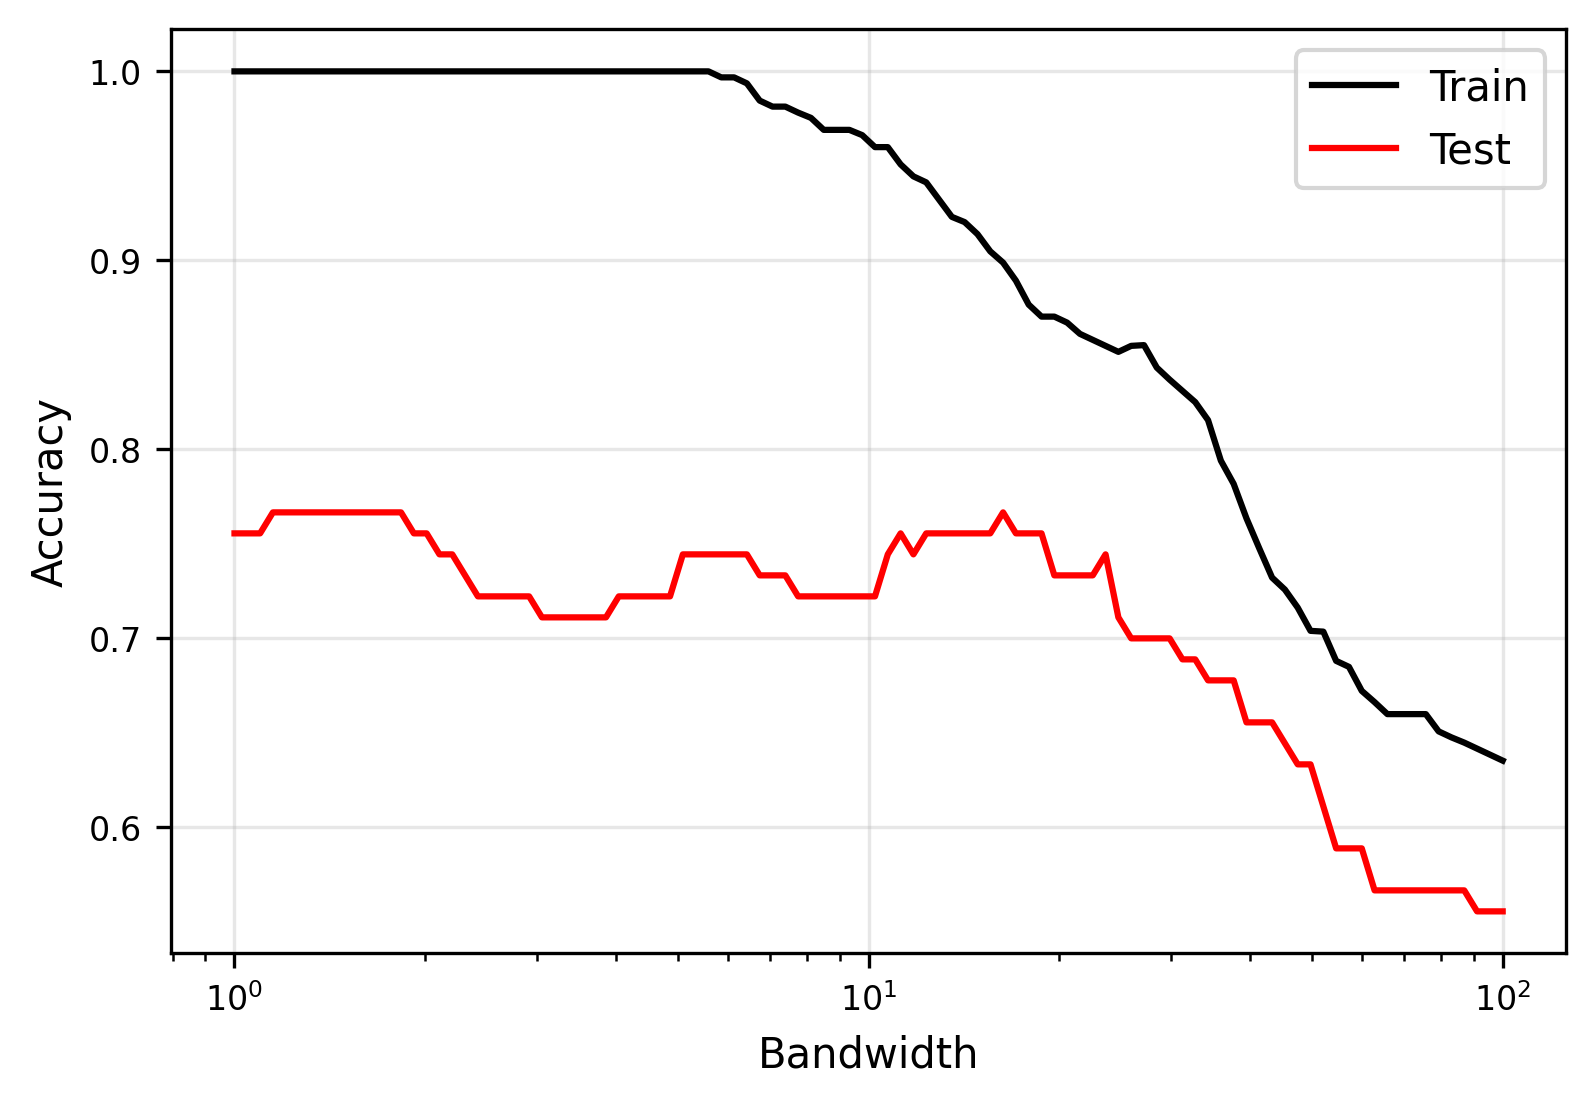

In [ ]:
plt.figure(dpi=300, figsize=(6,4))
plt.grid(alpha=0.3)
plt.semilogx(bandwidths, cv_train, label='Train', c='k')
plt.semilogx(bandwidths, cv_test, label='Test', c='r')
plt.xlabel('Bandwidth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
'''
Kernel x Accuracy
'''

kernels = ['gaussian','tophat','epanechnikov','exponential','linear','cosine']
param_grid = {
    'bandwidth': [1.0],
    'kernel': kernels,
    'distance': ['euclidean']
    }

group_kfold = GroupKFold(n_splits=5)
cvspliter   = group_kfold.split(X, y, Cultivar)

clf = GridSearchCV(KDEClassifier(), param_grid, cv=cvspliter, scoring='accuracy', return_train_score=True)
clf.fit(X, y)

cv_test  = clf.cv_results_['mean_test_score']
cv_train = clf.cv_results_['mean_train_score']

print('Maximum acc:')
print('\tTrain: ', )
print('\t\t Acc: ', np.max(cv_train))
print('\n\tTest: ', )
print('\t\t Acc: ', np.max(cv_test))

Maximum acc:
	Train: 
		 Acc:  1.0

	Test: 
		 Acc:  0.7555555555555555


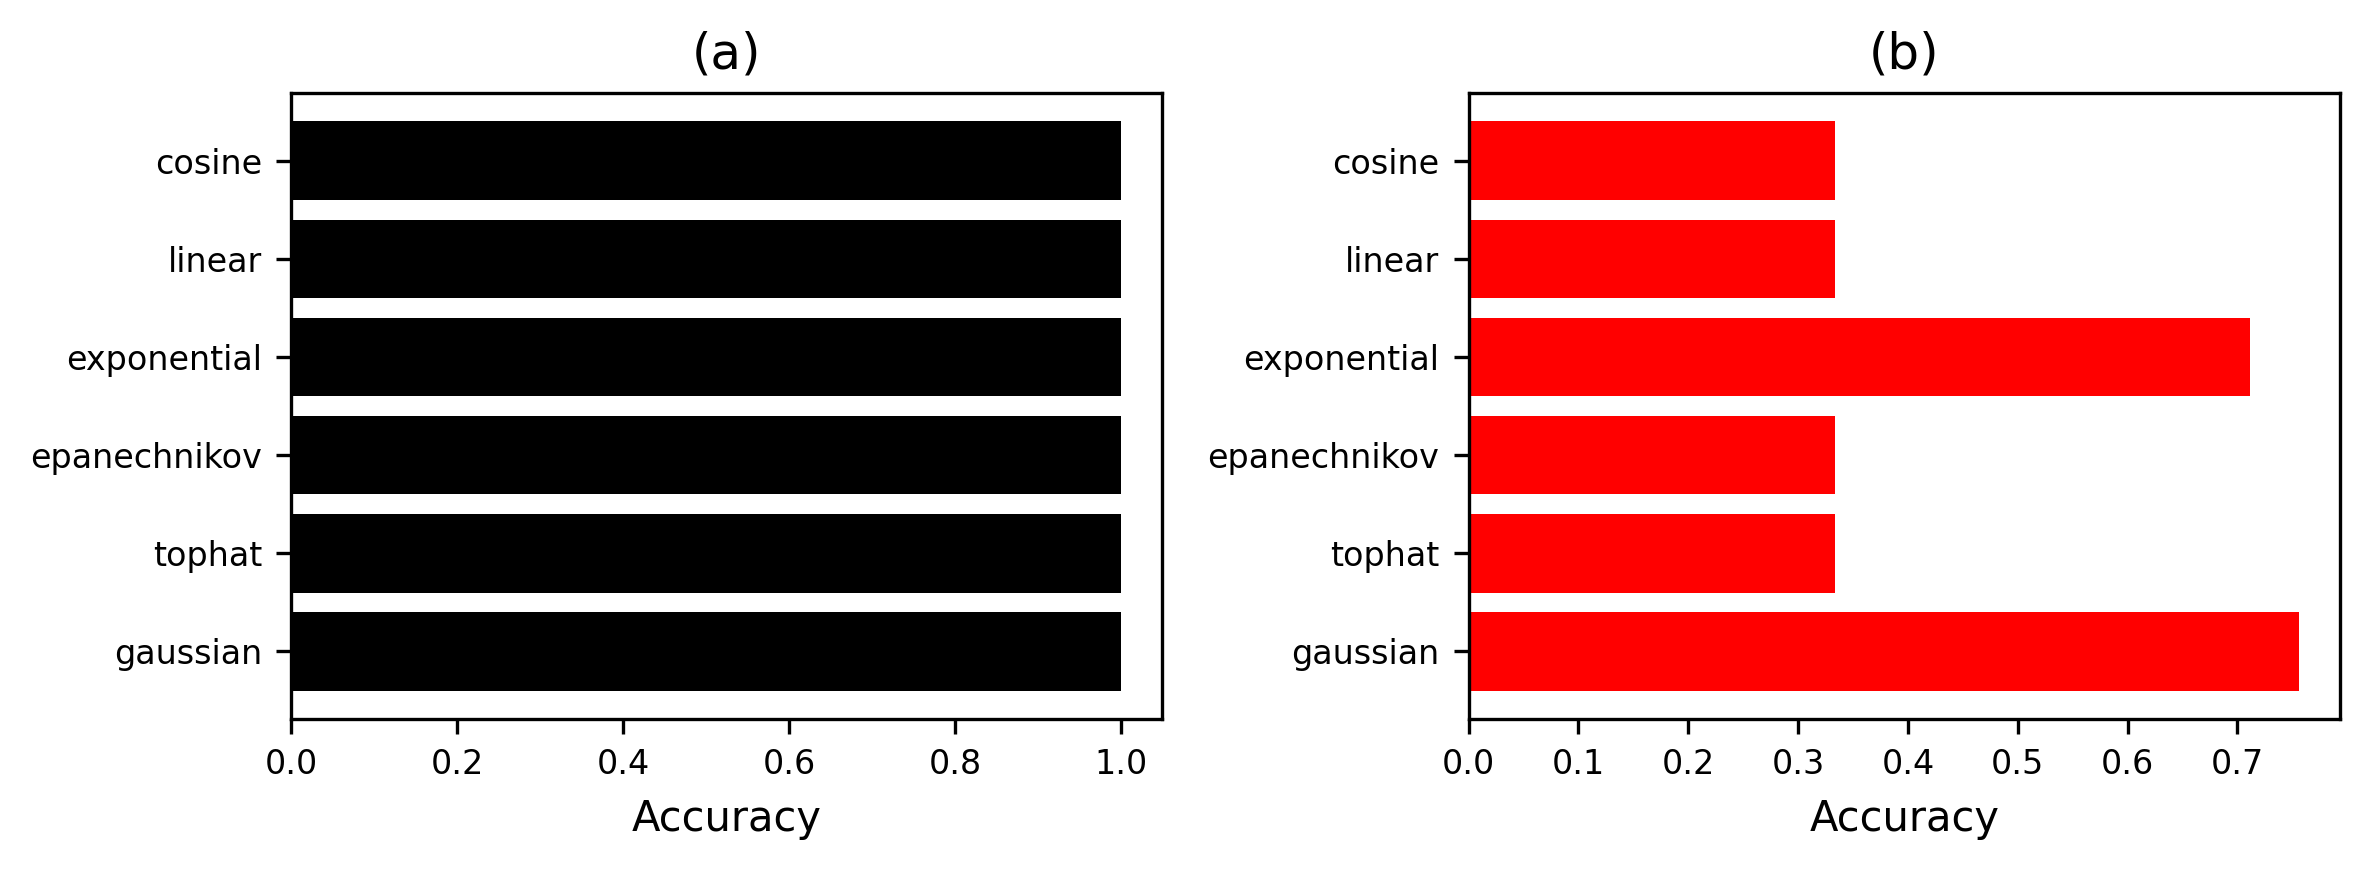

In [ ]:
plt.figure(dpi=300, figsize=(8,3))

plt.subplot(121)
plt.title('(a)')
plt.barh(kernels, cv_train, color='k')
plt.xlabel('Accuracy')

plt.subplot(122)
plt.title('(b)')
plt.barh(kernels, cv_test, color='r')
plt.xlabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
'''
Distance x Accuracy
'''
distances = ['euclidean', 'manhattan', 'chebyshev']
param_grid = {
    'bandwidth': [1.0],
    'kernel': ['gaussian'],
    'distance': distances
    }

group_kfold = GroupKFold(n_splits=5)
cvspliter   = group_kfold.split(X, y, Cultivar)

clf = GridSearchCV(KDEClassifier(), param_grid, cv=cvspliter, scoring='accuracy', return_train_score=True)
clf.fit(X, y)

cv_test  = clf.cv_results_['mean_test_score']
cv_train = clf.cv_results_['mean_train_score']

print('Maximum acc:')
print('\tTrain: ', )
print('\t\t Acc: ', np.max(cv_train))
print('\n\tTest: ', )
print('\t\t Acc: ', np.max(cv_test))

Maximum acc:
	Train: 
		 Acc:  1.0

	Test: 
		 Acc:  0.7777777777777778


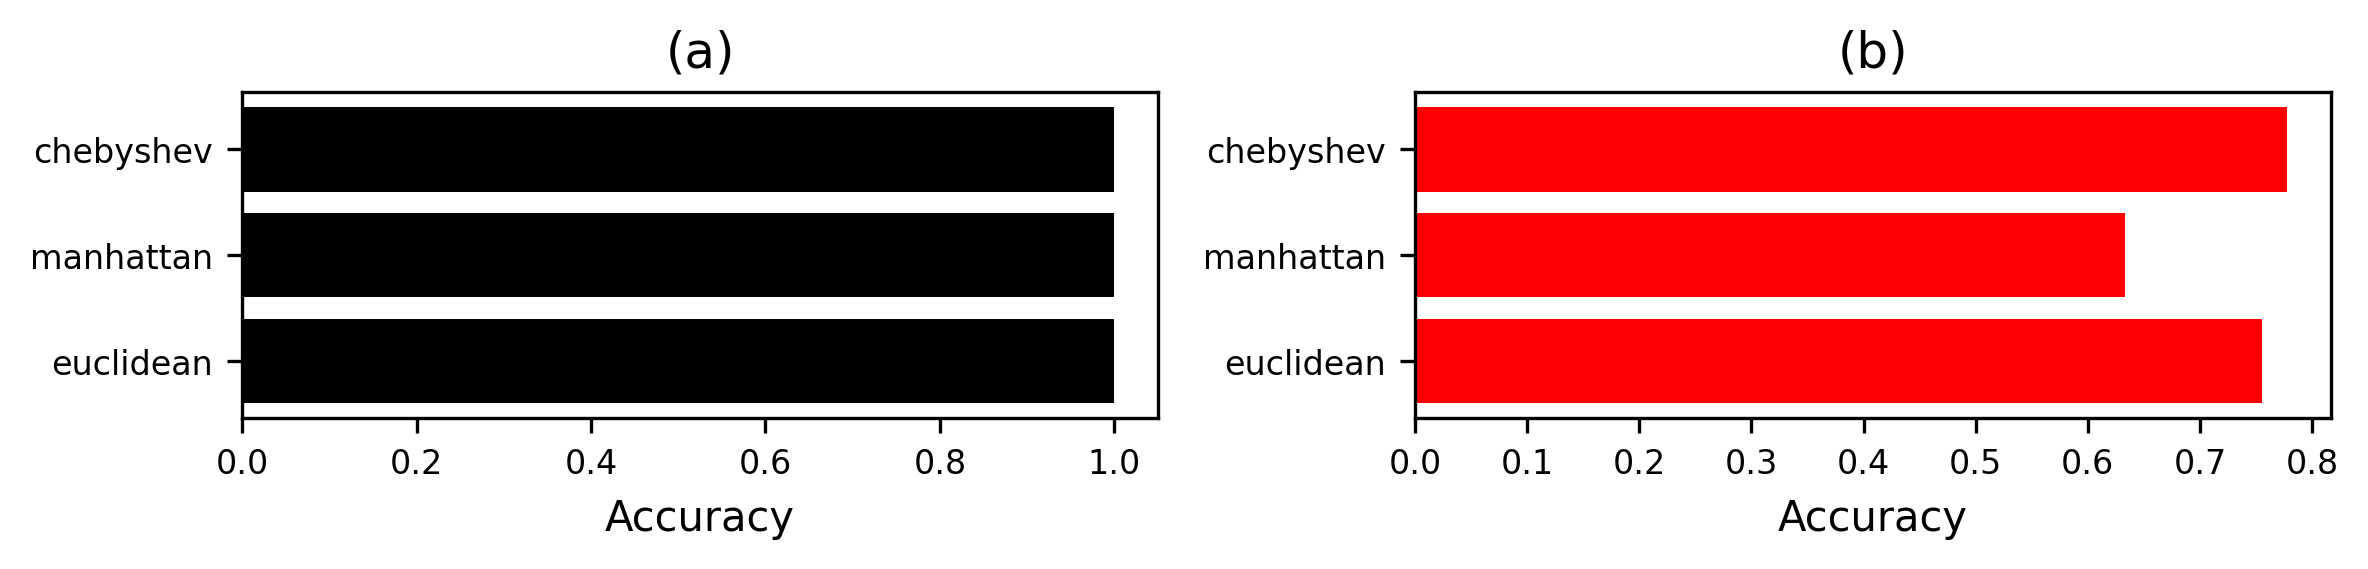

In [ ]:
plt.figure(dpi=300, figsize=(8,2))

plt.subplot(121)
plt.title('(a)')
plt.barh(distances, cv_train, color='k')
plt.xlabel('Accuracy')

plt.subplot(122)
plt.title('(b)')
plt.barh(distances, cv_test, color='r')
plt.xlabel('Accuracy')

plt.tight_layout()
plt.show()

# Employs the KDE Classifier

# Grouped CV

In [ ]:
'''
Grouped CV

KDEClassifier with fixed parameter, over 5-fold, using the measures of accuracy,
precision and recall and confusion matrix

Stores the cultivars that generate most prediction errors

Best hyper-paramters
{'bandwidth': 1.1497569953977358, 'distance': 'chebyshev', 'kernel': 'gaussian'}
0.7914285714285714
'''

# Lists for storing performance results
acc_train = []
acc_test  = []

pr_train = []
pr_test  = []

re_train = []
re_test  = []

mc_train = []
mc_test  = []

# For storing the best model
best_clf = None
best_acc = 0

# For storing cultivar prediction erros
Cultivars_errs_train = {}
Cultivars_errs_test  = {}

for cultivar in Cultivar:
    Cultivars_errs_train[cultivar] = 0
    Cultivars_errs_test[cultivar]  = 0

# K fold per group
group_kfold = GroupKFold(n_splits=5)

K = 1
for train_index, test_index in group_kfold.split(X, y, Cultivar):
    print('\n\n # Fold %i' %K)
    print('\nCultivares: ')
    print('\tTrain: ', np.unique(Cultivar[train_index]))
    print('\tTest: ', np.unique(Cultivar[test_index]))

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = KDEClassifier(bandwidth=1.1497569953977358, kernel='gaussian', distance='chebyshev')
    #clf = GaussianNB()
    clf.fit(X_train, y_train)

    y_pred_train = clf.predict(X_train)
    y_pred_test  = clf.predict(X_test)

    for i, x_train in enumerate(X_train):
        if y_pred_train[i] != y_train[i]:
            Cultivars_errs_train[Cultivar[train_index[i]]] += 1

    for i, x_test in enumerate(X_test):
        if y_pred_test[i] != y_test[i]:
            Cultivars_errs_test[Cultivar[test_index[i]]] += 1

    r_acc_train = accuracy_score(y_train, y_pred_train)
    r_acc_test  = accuracy_score(y_test, y_pred_test)
    acc_train.append(r_acc_train)
    acc_test.append(r_acc_test )

    if r_acc_test > best_acc:
        best_clf = clf
        best_acc = r_acc_test

    r_pr_train = precision_score(y_train, y_pred_train, average='weighted')
    r_pr_test  = precision_score(y_test, y_pred_test, average='weighted')
    pr_train.append(r_pr_train)
    pr_test.append(r_pr_test)

    r_re_train = f1_score(y_train, y_pred_train, average='weighted')
    r_re_test  = f1_score(y_test, y_pred_test, average='weighted')
    re_train.append(r_re_train)
    re_test.append(r_re_test)

    r_mc_train = confusion_matrix(y_train, y_pred_train)
    r_mc_test  = confusion_matrix(y_test, y_pred_test)
    mc_train.append(r_mc_train)
    mc_test.append(r_mc_test)

    print('Training: ')
    print('\tAcc: %.6f - Pr: %.6f - F1: %.6f' %(r_acc_train, r_pr_train, r_re_train))
    print('Test: ')
    print('\tAcc: %.6f - Pr: %.6f - F1: %.6f' %(r_acc_test, r_pr_test, r_re_test))

    K = K + 1

acc_train = np.array(acc_train)
acc_test  = np.array(acc_test)

pr_train = np.array(pr_train)
pr_test  = np.array(pr_test)

re_train = np.array(re_train)
re_test  = np.array(re_test)

mc_train = np.array(mc_train)
mc_test  = np.array(mc_test )

print('\nAverage - Training')
print('\t Acc: %.6f - Pr: %.6f - F1: %.6f' %(acc_train.mean(), pr_train.mean(), re_train.mean()))
print('Average - Test')
print('\t Acc: %.6f - Pr: %.6f - F1: %.6f' %(acc_test.mean(), pr_test.mean(), re_test.mean()))

print('\n\nPrediction errors per Cultivar')
print('\nTraining')
print(Cultivars_errs_train)
print('Test')
print(Cultivars_errs_test)



 # Fold 1

Cultivares: 
	Train:  ['ADR 300' 'Aruana' 'BRS Piatã' 'Marandu' 'Mombaça' 'Pojuca' 'Tanzânia']
	Test:  ['Comum' 'Xaraés']
Training: 
	Acc: 1.000000 - Pr: 1.000000 - F1: 1.000000
Test: 
	Acc: 0.888889 - Pr: 0.904762 - F1: 0.882051


 # Fold 2

Cultivares: 
	Train:  ['ADR 300' 'Aruana' 'Comum' 'Marandu' 'Mombaça' 'Pojuca' 'Xaraés']
	Test:  ['BRS Piatã' 'Tanzânia']
Training: 
	Acc: 1.000000 - Pr: 1.000000 - F1: 1.000000
Test: 
	Acc: 0.722222 - Pr: 0.734921 - F1: 0.725330


 # Fold 3

Cultivares: 
	Train:  ['ADR 300' 'BRS Piatã' 'Comum' 'Marandu' 'Mombaça' 'Tanzânia' 'Xaraés']
	Test:  ['Aruana' 'Pojuca']
Training: 
	Acc: 1.000000 - Pr: 1.000000 - F1: 1.000000
Test: 
	Acc: 0.722222 - Pr: 0.716270 - F1: 0.693936


 # Fold 4

Cultivares: 
	Train:  ['Aruana' 'BRS Piatã' 'Comum' 'Marandu' 'Pojuca' 'Tanzânia' 'Xaraés']
	Test:  ['ADR 300' 'Mombaça']
Training: 
	Acc: 1.000000 - Pr: 1.000000 - F1: 1.000000
Test: 
	Acc: 0.833333 - Pr: 0.888889 - F1: 0.822222


 # Fold 5

Cultivares: 
	T

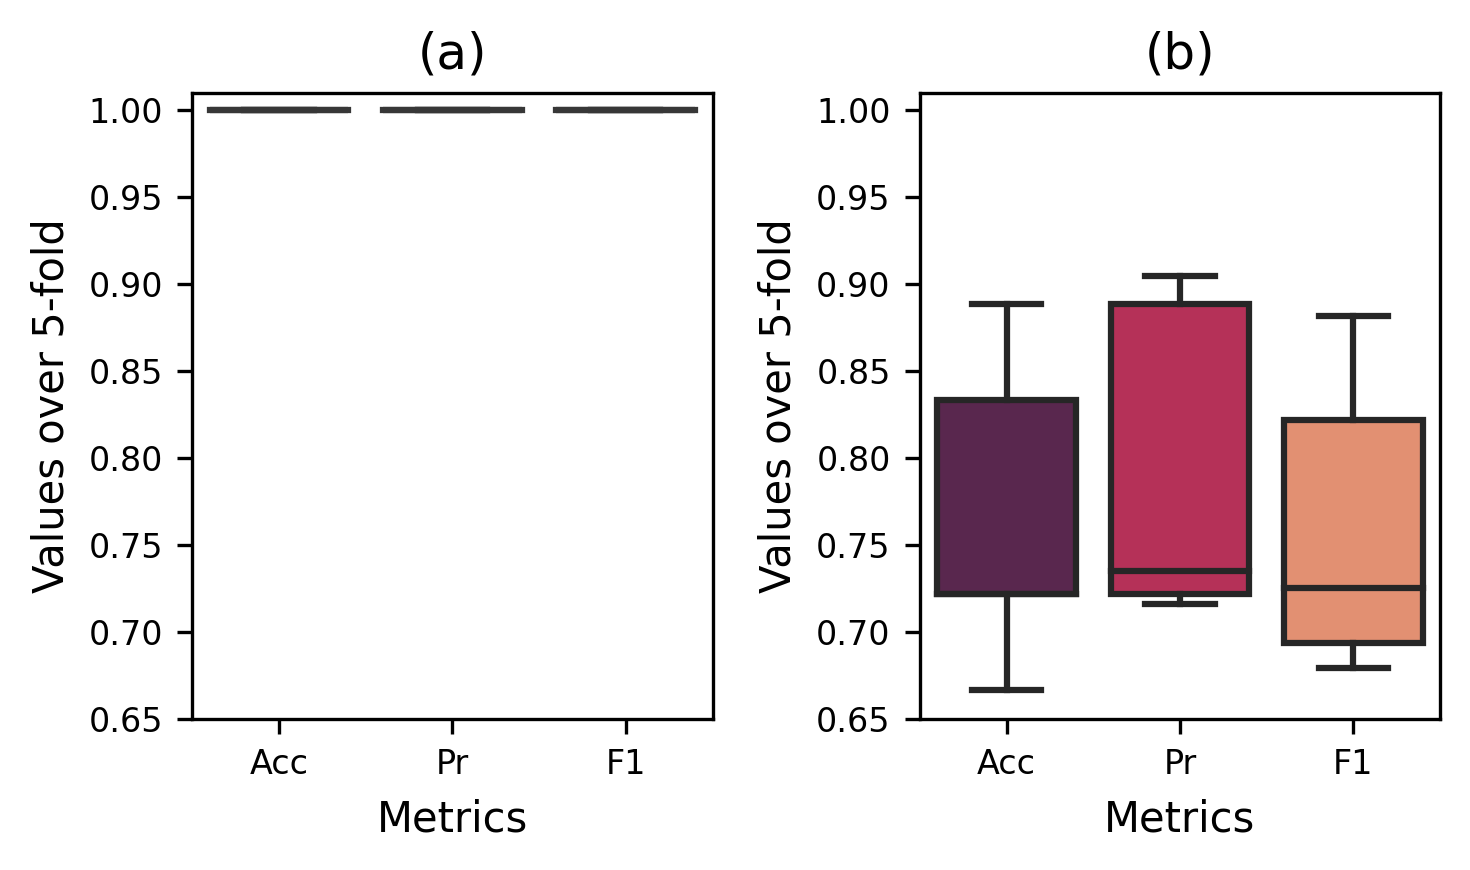

In [ ]:
df_train = pd.DataFrame()
df_train['Acc'] = acc_train
df_train['Pr']  = pr_train
df_train['F1']  = re_train

df_test = pd.DataFrame()
df_test['Acc'] = acc_test
df_test['Pr']  = pr_test
df_test['F1']  = re_test


plt.figure(dpi=300, figsize=(5,3))
plt.subplot(121)
plt.title('(a)')
sns.boxplot(data=df_train, palette="flare")
plt.ylim((0.65, 1.01))
plt.xlabel('Metrics')
plt.ylabel('Values over 5-fold')
plt.subplot(122)
plt.title('(b)')
sns.boxplot(data=df_test, palette='rocket')
plt.ylim((0.65, 1.01))
plt.xlabel('Metrics')
plt.ylabel('Values over 5-fold')
plt.tight_layout()
plt.show()

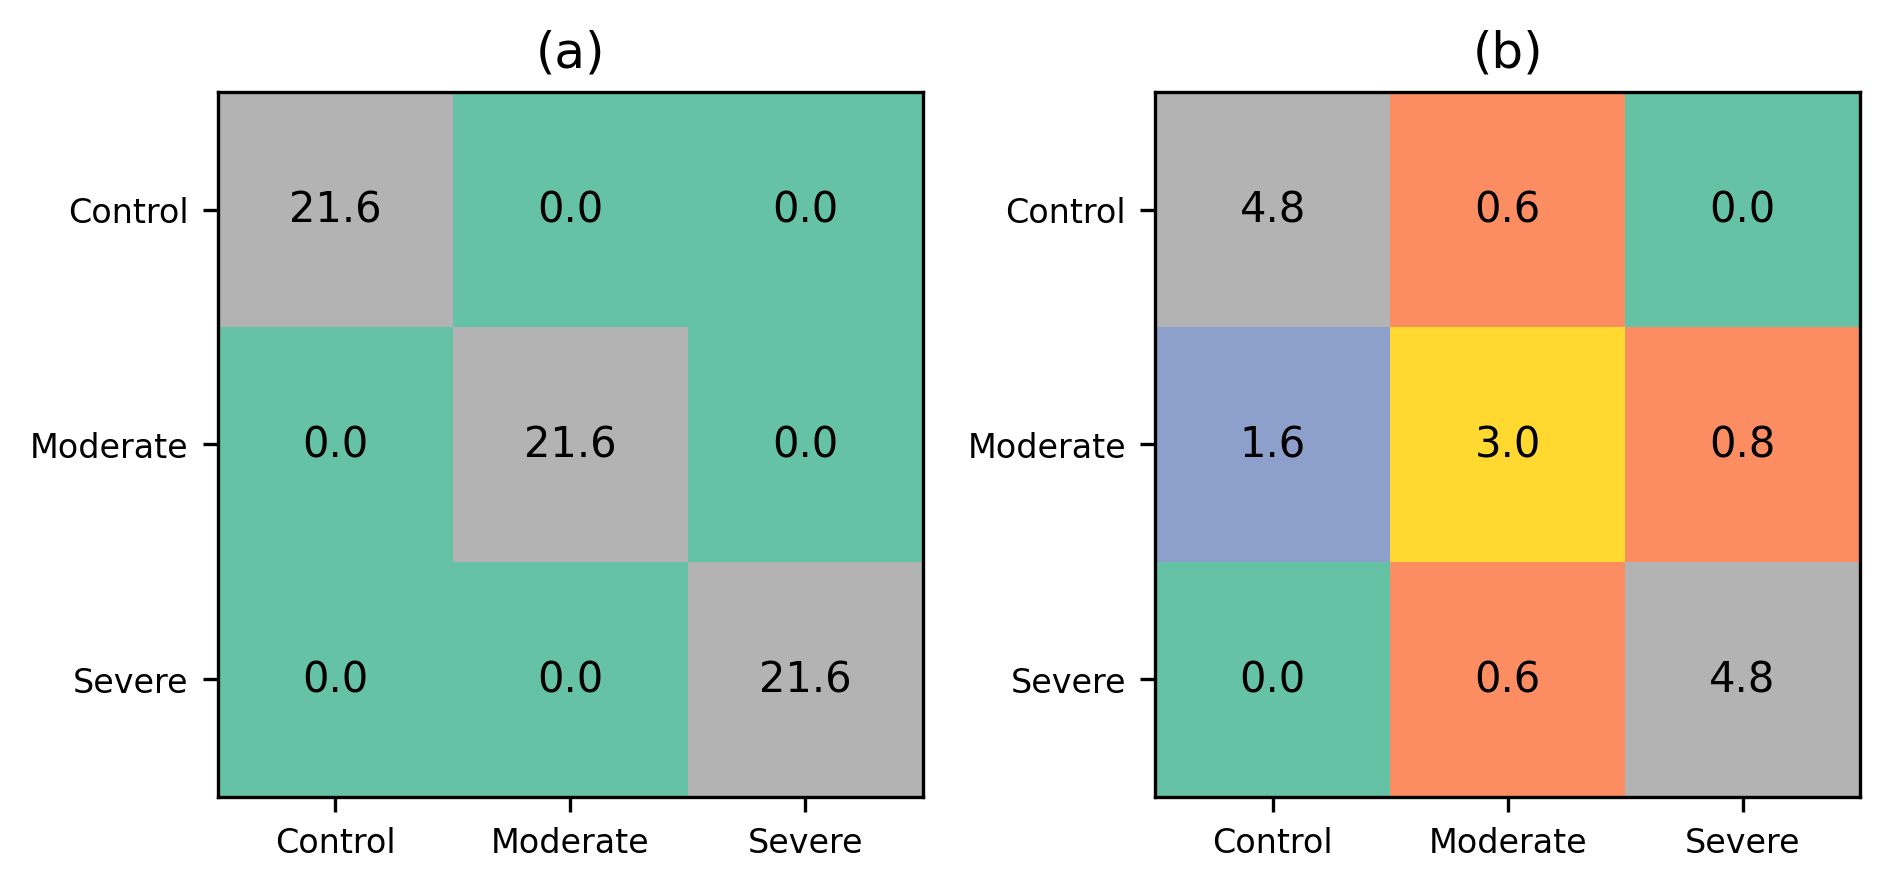

In [ ]:
'''
Plot the average confusion matrix
'''
classes = ["Control", "Moderate", "Severe"]

MC_train = np.round(np.mean(mc_train, axis=0), 2)
MC_test  = np.round(np.mean(mc_test, axis=0), 2)

fig = plt.figure(dpi=300)
plt.subplot(121)
plt.imshow(MC_train, cmap='Set2')
plt.title('(a)')
plt.xticks(np.arange(len(classes)), labels=classes)
plt.yticks(np.arange(len(classes)), labels=classes)

# Loop over data dimensions and create text annotations.
for k in range(len(classes)):
    for j in range(len(classes)):
        text = plt.text(j, k, MC_train[k, j], ha="center", va="center", color="k")

plt.subplot(122)
plt.imshow(MC_test, cmap='Set2')
plt.title('(b)')
plt.xticks(np.arange(len(classes)), labels=classes)
plt.yticks(np.arange(len(classes)), labels=classes)

# Loop over data dimensions and create text annotations.
for k in range(len(classes)):
    for j in range(len(classes)):
        text = plt.text(j, k, MC_test[k, j], ha="center", va="center", color="k")

fig.tight_layout()
plt.show()

# Show probability density

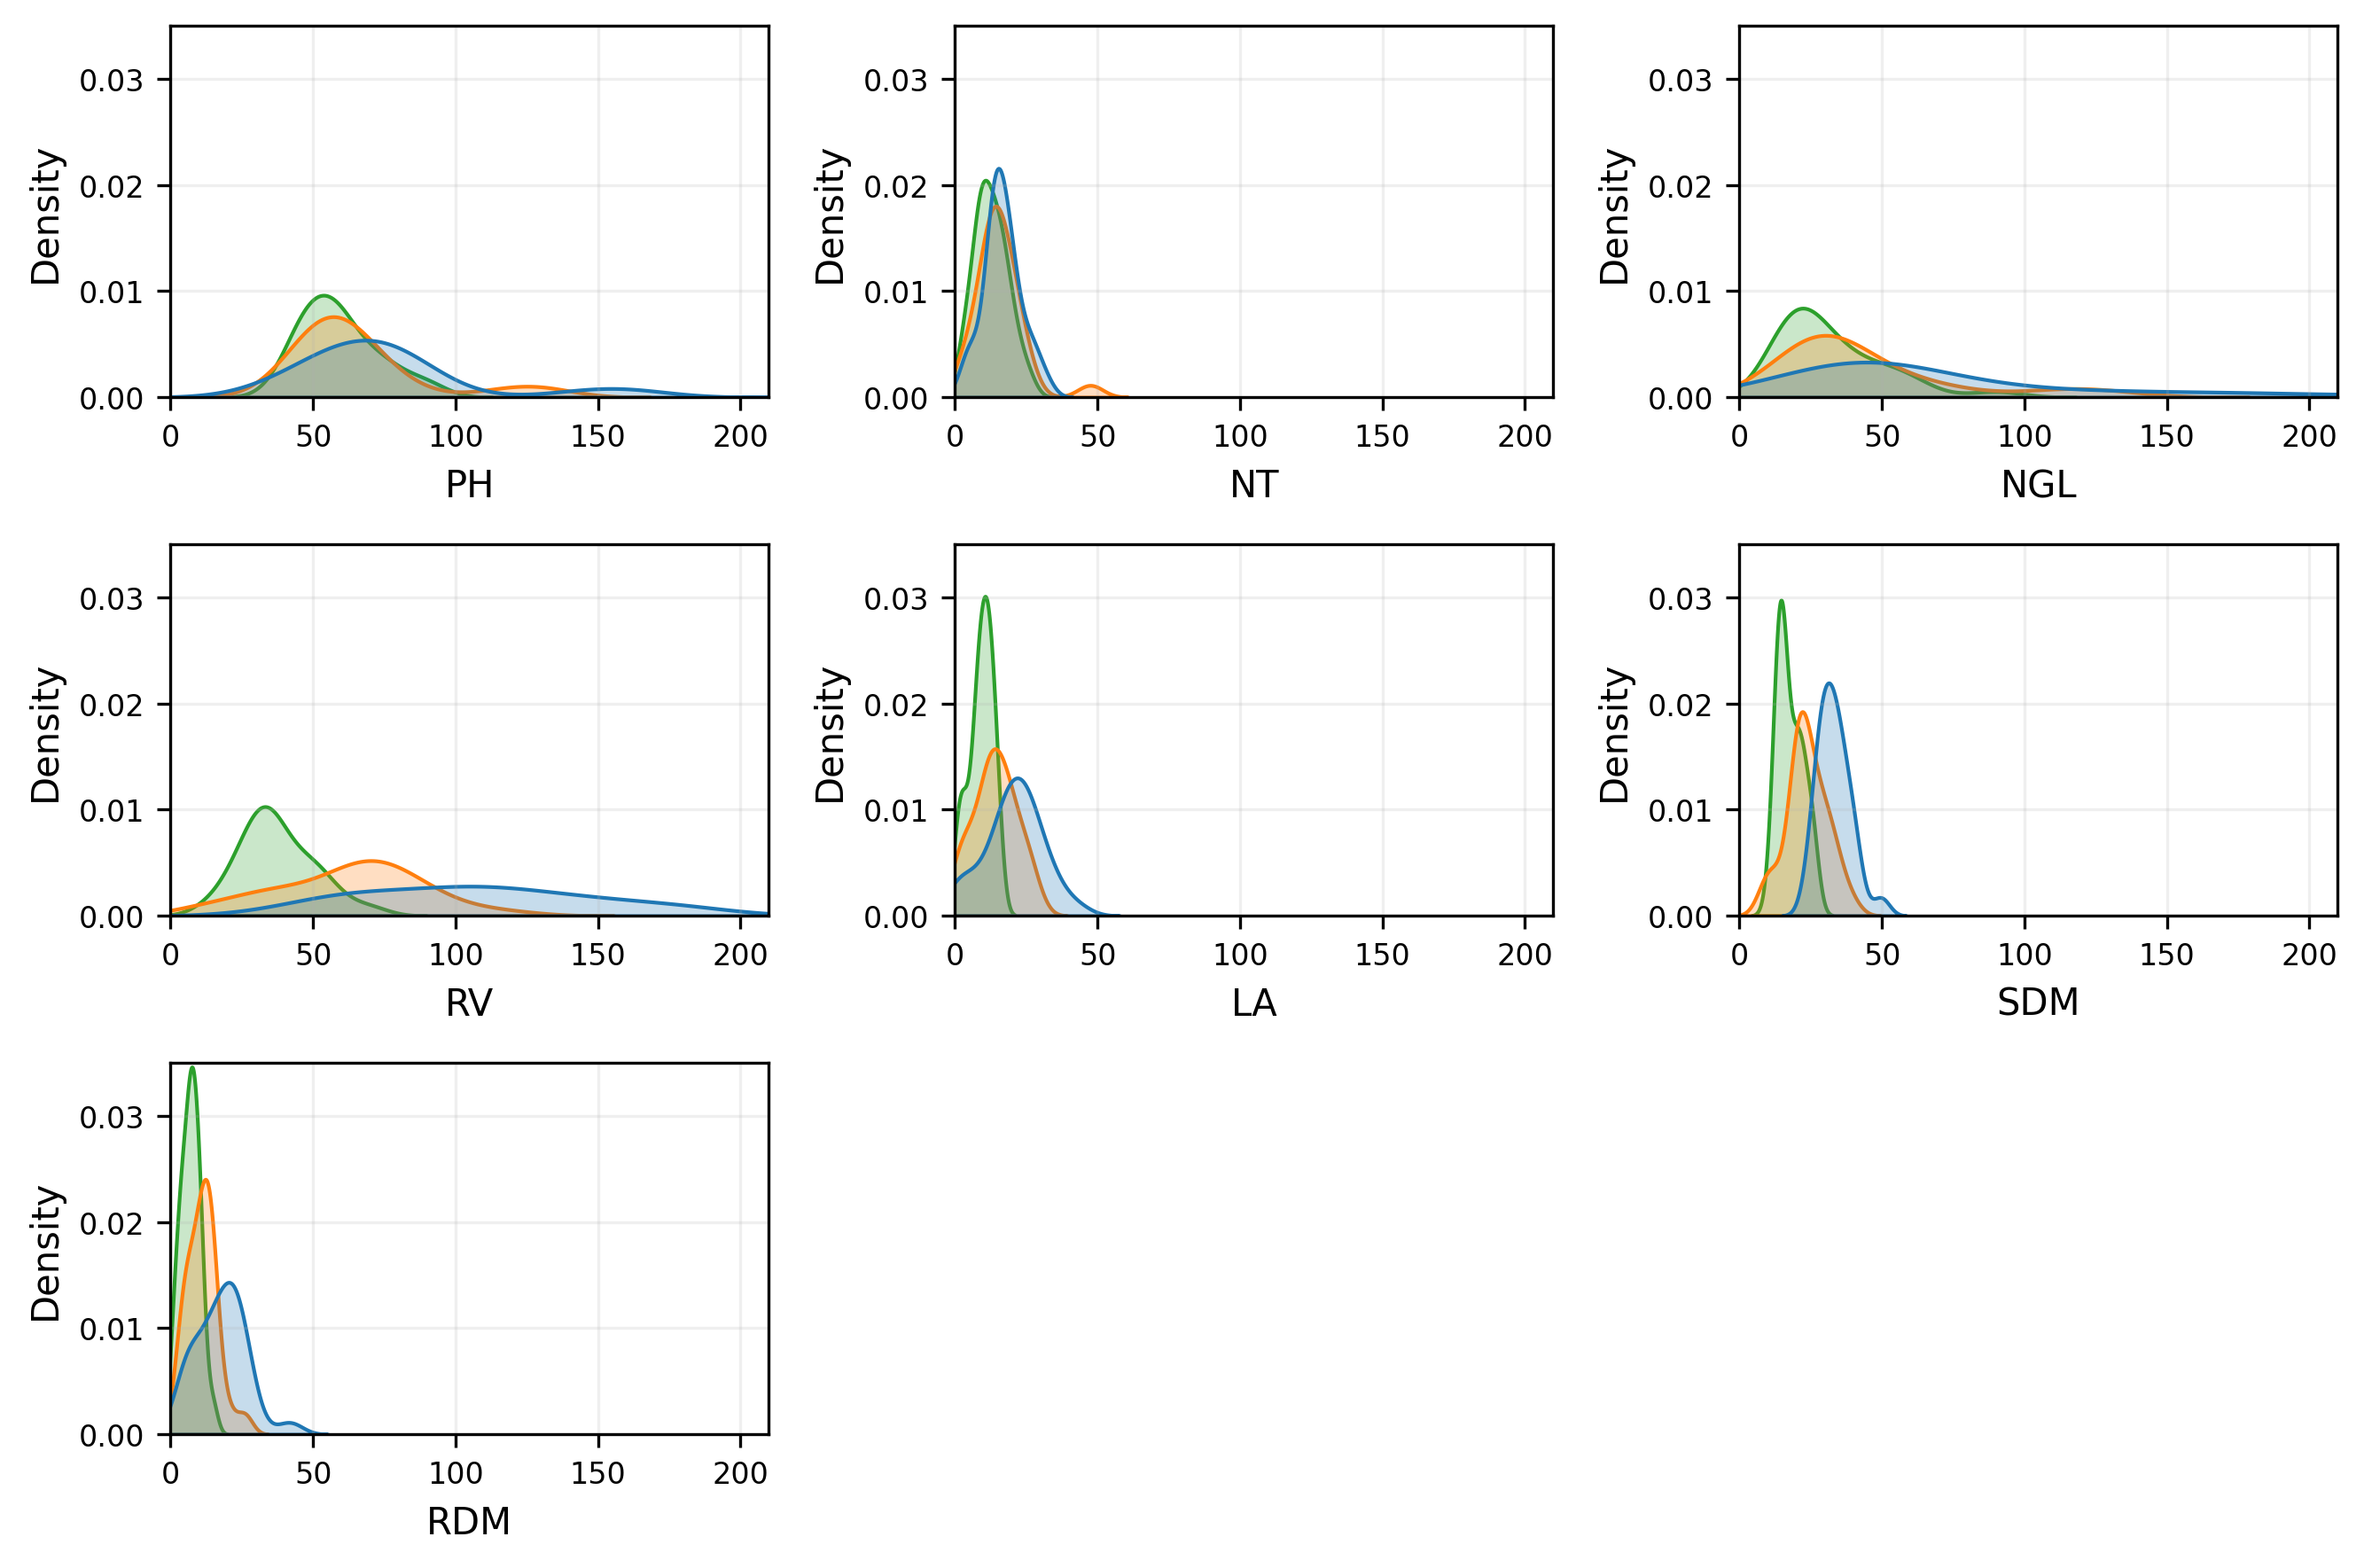

In [ ]:
plt.figure(dpi=300, figsize=(9,6))

for j, var in enumerate(Vars):
    plt.subplot(3, 3, j + 1)
    sns.kdeplot(data=df, x=var, hue='Class', fill=True)
    ma = max(df[var])
    mi = min(df[var])
    plt.xlim([0, 210])
    plt.ylim([0, 0.035])
    plt.grid(alpha=0.2)
    plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()